In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Nov 21 13:36:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1Z_RSO1UKRfJXdL47MthB0iPpSXRNqd1D --output "data.zip"
!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1Z_RSO1UKRfJXdL47MthB0iPpSXRNqd1D
To: /content/data.zip
100% 642M/642M [00:02<00:00, 231MB/s]


In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 8.6 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 180 kB 63.9 MB/s 
     |████████████████████████████████| 140 kB 74.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=9e8aefe2a21ee9650e15b5348c56133a4dcf9e46f90d6455c14103cec843582b
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=fcd9ccf38e1cad6e219e836f25b81c97845f52d354d42cee663ca79ad5b96719
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import os
import glob
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

class myDataset(Dataset):
    def __init__(self, root, label_data=None, transform=None):
        self.transform = transform
        self.label_data = label_data

        self.img_paths = []
        self.labels = []

        if label_data is not None:
            for d in self.label_data:
                img_path, label = d.split(',')
                self.img_paths.append(os.path.join(root, img_path))
                self.labels.append(int(label))
        else:
            for fn in glob.glob(os.path.join(root, '*.png')):
                self.img_paths.append(fn)
                self.labels.append(0)

        self.len = len(self.img_paths)


    def __getitem__(self, index):
        """ Get a sample from the dataset """
        image_fn, label = self.img_paths[index], self.labels[index]
        image = Image.open(image_fn).convert('RGB')
            
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        """ Total number of samples in the dataset """
        return self.len


class myDataset_2(Dataset):
    def __init__(self, root, label_data=None, transform=None):
        self.transform = transform
        self.label_data = label_data
        self.images = []
        self.labels = []

        if label_data is not None:
            for d in self.label_data:
                img_path, label = d.split(',')
                image = Image.open(os.path.join(root, img_path)).convert('RGB')
                if self.transform is not None:
                    image = self.transform(image)
                    
                self.images.append(image)
                self.labels.append(int(label))
        else:
            for fn in glob.glob(os.path.join(root, '*.png')):
                image = Image.open(fn).convert('RGB')
                if self.transform is not None:
                    image = self.transform(image)

                self.images.append(image)
                self.labels.append(0)

        self.len = len(self.images)


    def __getitem__(self, index):
        """ Get a sample from the dataset """
        image, label = self.images[index], self.labels[index]

        return image, label

    def __len__(self):
        """ Total number of samples in the dataset """
        return self.len

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None



class DANN(nn.Module):
    def __init__(self, code_size=512, n_class=10):
        super(DANN, self).__init__()
        
        self.feature_extractor_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.feature_extractor_fc = nn.Sequential(
            nn.Linear(50 * 4 * 4, code_size),
            nn.BatchNorm1d(code_size),
            nn.Dropout(),
            nn.ReLU(True)
        )
        
        self.class_classifier = nn.Sequential(
            nn.Linear(code_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, n_class),
            nn.LogSoftmax(dim=1)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(code_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1)
        )

    def encode(self, x):
        feature = self.feature_extractor_conv(x)
        feature = feature.view(-1, 50 * 4 * 4)
        feature = self.feature_extractor_fc(feature)

        return feature


    def forward(self, x, alpha=1.0):
        feature = self.feature_extractor_conv(x)
        feature = feature.view(-1, 50 * 4 * 4)
        feature = self.feature_extractor_fc(feature)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)
        
        return class_output, domain_output

In [ ]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
# from model import DANN


class Solver(object):
    def __init__(self, src_trainset_loader, src_valset_loader, tgt_trainset_loader=None, config=None):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.use_cuda else 'cpu')
        self.src_trainset_loader = src_trainset_loader
        self.src_valset_loader = src_valset_loader
        self.tgt_trainset_loader = tgt_trainset_loader
        self.num_iters = config.num_iters
        self.resume_iters = config.resume_iters
        self.lr = config.lr
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.src_only = config.src_only
        self.exp_name = config.name
        os.makedirs(config.ckp_dir, exist_ok=True)
        self.ckp_dir = os.path.join(config.ckp_dir, self.exp_name)
        os.makedirs(self.ckp_dir, exist_ok=True)
        self.log_interval = config.log_interval
        self.save_interval = config.save_interval
        self.use_wandb = config.use_wandb
        
        self.build_model()

    def build_model(self):
        self.model = DANN().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr,  betas=[self.beta1, self.beta2])

    def save_checkpoint(self, step):
        state = {'state_dict': self.model.state_dict(),
                 'optimizer' : self.optimizer.state_dict()}
        new_checkpoint_path = os.path.join(self.ckp_dir, '{}-dann.pth'.format(step + 1))
        torch.save(state, new_checkpoint_path)
        print('model saved to %s' % new_checkpoint_path)

    def load_checkpoint(self, resume_iters):
        print('Loading the trained models from step {}...'.format(resume_iters))
        new_checkpoint_path = os.path.join(self.ckp_dir, '{}-dann.pth'.format(resume_iters))
        state = torch.load(new_checkpoint_path)
        self.model.load_state_dict(state['state_dict'])
        self.optimizer.load_state_dict(state['optimizer'])
        print('model loaded from %s' % new_checkpoint_path)

    def reset_grad(self):
        """Reset the gradient buffers."""
        self.optimizer.zero_grad()
    
    def train(self):
        criterion = nn.NLLLoss()

        best_acc = 0
        best_loss = 1e15
        iteration = 0
        if self.resume_iters:
            print("resuming step %d ..."% self.resume_iters)
            iteration = self.resume_iters
            self.load_checkpoint(self.resume_iters)
            best_loss, best_acc = self.eval()

        while iteration < self.num_iters:
            self.model.train()  
            self.optimizer.zero_grad()

            try:
                data, label = next(src_data_iter)
            except:
                src_data_iter = iter(self.src_trainset_loader)
                data, label = next(src_data_iter)

            data, label = data.to(self.device), label.to(self.device)
            src_batch_size = data.size(0)

            
            p = float(iteration) / (self.num_iters)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            src_domain = torch.zeros((src_batch_size,), dtype=torch.long, device=self.device)

            class_output, domain_output = self.model(data, alpha)

            src_c_loss = criterion(class_output, label)
            src_d_loss = criterion(domain_output, src_domain)

            loss = src_c_loss + src_d_loss

            if self.src_only:
                tgt_d_loss = torch.zeros(1)

            else:
                try:
                    tgt_data, _ = next(tgt_data_iter)
                except:
                    tgt_data_iter = iter(self.tgt_trainset_loader)
                    tgt_data, _ = next(tgt_data_iter)

                tgt_data = tgt_data.to(self.device)
                tgt_batch_size = tgt_data.size(0)
                tgt_domain = torch.ones((tgt_batch_size,), dtype=torch.long, device=self.device)

                _, domain_output = self.model(tgt_data, alpha)
                tgt_d_loss = criterion(domain_output, tgt_domain)

                loss += tgt_d_loss

            
            loss.backward()
            self.optimizer.step()

            # Output training stats
            if (iteration+1) % self.log_interval == 0:
                print('Iteration: {:5d}\tloss: {:.6f}\tloss_src_class: {:.6f}\tloss_src_domain: {:.6f}\tloss_tgt_domain: {:.6f}'.format(
                    iteration + 1, 
                    loss.item(), src_c_loss.item(), src_d_loss.item(), tgt_d_loss.item()))

                if self.use_wandb:
                    import wandb
                    wandb.log({"loss": loss.item(),
                               "loss_src_class": src_c_loss.item(),
                               "loss_src_domain": src_d_loss.item(),
                               "loss_tgt_domain": tgt_d_loss.item()}, 
                               step=iteration+1)

            # Save model checkpoints
            if (iteration+1) % self.save_interval == 0 and iteration > 0:
                val_loss, val_acc = self.eval()
                if self.use_wandb:
                    import wandb
                    wandb.log({"val_loss": val_loss,
                               "val_acc": val_acc}, step=iteration+1, commit=False)

                self.save_checkpoint(iteration)

                if (val_acc > best_acc):
                    print('val acc: %.2f > %.2f' % (val_acc, best_acc))
                    best_acc = val_acc
                if (val_loss < best_loss):
                    print('val loss: %.4f < %.4f' % (val_loss, best_loss))
                    best_loss = val_loss

            iteration += 1


    def eval(self):
        criterion = nn.CrossEntropyLoss()
        self.model.eval()
        val_loss = 0.0
        correct = 0.0
        with torch.no_grad():
            for data, label in self.src_valset_loader:
                data, label = data.to(self.device), label.to(self.device)
                output, _ = self.model(data)
                val_loss += criterion(output, label).item()
                pred = torch.exp(output).max(1, keepdim=True)[1]
                correct += pred.eq(label.view_as(pred)).sum().item()

        val_loss /= len(self.src_valset_loader)
        val_acc = 100. * correct / len(self.src_valset_loader.dataset)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.  format(
            val_loss, correct, len(self.src_valset_loader.dataset), val_acc))

        return val_loss, val_acc

In [ ]:
import os
import argparse
# from solver import Solver
# from dataset import myDataset, myDataset_2
from torch.backends import cudnn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from argparse import Namespace


def main(config):
    # For fast training.
    cudnn.benchmark = True

    if config.use_wandb:
        import wandb
        wandb.init(project="dlcv-hw2-3", config=config)
        #wandb.config.update(vars(args))
        config = wandb.config
        print(config)

    label_path = os.path.join(config.data_path, config.src_domain, 'train.csv')
    src_root = os.path.join(config.data_path, config.src_domain, 'train')

    src_label_data = []
    with open(label_path) as f:
        src_label_data += f.readlines()[1:]

    src_label_train, src_label_val = train_test_split(src_label_data, test_size=0.25, shuffle=True)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

    transform_aug = transforms.Compose([
        transforms.ColorJitter(
            brightness=63.0 / 255.0, saturation=[0.5, 1.5], contrast=[0.2, 1.8]
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

    if config.data_aug:
        src_trainset = myDataset(root=src_root, label_data=src_label_train, transform=transform_aug)

    else:
        src_trainset = myDataset(root=src_root, label_data=src_label_train, transform=transform)

    src_trainset_loader = DataLoader(src_trainset, batch_size=config.batch_size, shuffle=True, num_workers=1)

    src_valset = myDataset(root=src_root, label_data=src_label_val, transform=transform)
    src_valset_loader = DataLoader(src_valset, batch_size=config.batch_size, shuffle=True, num_workers=1)

    if config.src_only:
        solver = Solver(src_trainset_loader, src_valset_loader, None, config)

    else:
        tgt_root = os.path.join(config.data_path, config.tgt_domain, 'train')
        tgt_trainset = myDataset(root=tgt_root, transform=transform)

        tgt_trainset_loader = DataLoader(tgt_trainset, batch_size=config.batch_size, shuffle=True, num_workers=1)

        solver = Solver(src_trainset_loader, src_valset_loader, tgt_trainset_loader, config)


    solver.train()
        
    
        

if __name__ == '__main__':
    # parser = argparse.ArgumentParser()

    # # path.
    # parser.add_argument('--data_path', type=str, default='../hw3_data/digits', help="the path of the dataset to train.")
    # parser.add_argument('--ckp_dir', default='ckpt/', type=str, help='Checkpoint path', required=False)
    # parser.add_argument('--name', default='', type=str, help='Name for saving model')
    # parser.add_argument('--src_domain', default='mnistm', type=str, choices=['mnistm', 'svhn', 'usps'], help='Name for source domain')
    # parser.add_argument('--tgt_domain', default='svhn', type=str, choices=['mnistm', 'svhn', 'usps'], help='Name for target domain')

    # # training configuration.
    # parser.add_argument('--batch_size', type=int, default=32, help='mini-batch size')
    # parser.add_argument('--num_iters', type=int, default=100000, help='number of total iterations')
    # parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')
    # parser.add_argument("--lr", help="the learning rate", default=1e-3, type=float)
    # parser.add_argument('--beta1', type=float, default=0.9, help='beta1 for Adam optimizer')
    # parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
    # parser.add_argument("--src_only", help="only train on src data", action="store_true")
    # parser.add_argument("--data_aug", help="data augmentation", action="store_true")

    # # Step size.
    # parser.add_argument('--log_interval', type=int, default=250)
    # parser.add_argument('--save_interval', type=int, default=1000)

    # # Others
    # parser.add_argument("--use_wandb", help="log training with wandb, "
    #     "requires wandb, install with \"pip install wandb\"", action="store_true")
    

    # config = parser.parse_args()

    parameters = {
        "data_path": '/content/hw2_data/digits',
        "ckp_dir": '/content/ckpt/',
        "name": '',
        "src_domain": 'usps',
        "tgt_domain": 'svhn',

        "batch_size": 32,
        "num_iters": 100000,
        "resume_iters": None,
        "lr": 1e-3,
        "beta1": 0.9,
        "beta2": 0.999,
        "src_only": False,
        "data_aug": True,

        "log_interval": 250,
        "save_interval": 1000,

        "use_wandb": False,
    }
    config = Namespace(**parameters)

    print(config)
    main(config)

Namespace(batch_size=32, beta1=0.9, beta2=0.999, ckp_dir='/content/ckpt/', data_aug=True, data_path='/content/hw2_data/digits', log_interval=250, lr=0.001, name='', num_iters=100000, resume_iters=None, save_interval=1000, src_domain='usps', src_only=False, tgt_domain='svhn', use_wandb=False)
Iteration:   250	loss: 1.580239	loss_src_class: 0.285899	loss_src_domain: 0.671323	loss_tgt_domain: 0.623017
Iteration:   500	loss: 1.101944	loss_src_class: 0.119560	loss_src_domain: 0.520593	loss_tgt_domain: 0.461791
Iteration:   750	loss: 0.760216	loss_src_class: 0.042871	loss_src_domain: 0.385772	loss_tgt_domain: 0.331574
Iteration:  1000	loss: 1.131244	loss_src_class: 0.251149	loss_src_domain: 0.451497	loss_tgt_domain: 0.428597

Val set: Average loss: 0.0624, Accuracy: 1795.0/1823 (98.46%)

model saved to /content/ckpt/1000-dann.pth
val acc: 98.46 > 0.00
val loss: 0.0624 < 1000000000000000.0000
Iteration:  1250	loss: 1.018577	loss_src_class: 0.061848	loss_src_domain: 0.483763	loss_tgt_domain: 0

KeyboardInterrupt: ignored

In [ ]:
!cp -r /content/drive/MyDrive/DLCV/HW2/hw2_2_models/ /content/

In [ ]:
import os
import argparse
import glob
# from dataset import myDataset
import torch
from torch.backends import cudnn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
# from model import DANN
from PIL import Image
from argparse import Namespace


def main(config):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    model = DANN().cuda()
    print(model)

    state = torch.load(config.ckp_path)
    model.load_state_dict(state['state_dict'])

    filenames = glob.glob(os.path.join(config.img_dir, '*.png'))
    filenames = sorted(filenames)

    out_filename = config.save_path
    os.makedirs(os.path.dirname(config.save_path), exist_ok=True)

    model.eval()
    with open(out_filename, 'w') as out_file:
        out_file.write('image_name,label\n')
        with torch.no_grad():
            for fn in filenames:
                data = Image.open(fn).convert('RGB')
                # print(data)
                data = transform(data)
                data = torch.unsqueeze(data, 0)
                data = data.cuda()
                output, _ = model(data, 1)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                out_file.write(fn.split('/')[-1] + ',' + str(pred.item()) + '\n')


if __name__ == '__main__':
    # parser = argparse.ArgumentParser()

    # # Training configuration.
    # parser.add_argument('--img_dir', type=str, default='../hw3_data/digits/svhn/test')
    # parser.add_argument('--save_path', type=str, default='ckpt/test')
    # parser.add_argument('--ckp_path', default='ckpt/test/3750-dann.pth', type=str, help='Checkpoint path.')
    

    # config = parser.parse_args()
    parameter = {
        "img_dir": '/content/hw2_data/digits/svhn/test',
        "save_path": '/content/ckpt/test',
        "ckp_path": "/content/hw2_2_models/14000-dann_us2.pth",
    }
    config = Namespace(**parameter)
    print(config)
    main(config)

Namespace(ckp_path='/content/hw2_2_models/14000-dann_us2.pth', img_dir='/content/hw2_data/digits/svhn/test', save_path='/content/ckpt/test')
DANN(
  (feature_extractor_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.5, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (feature_extractor_fc): Sequential(
    (0): Linear(in_features=800, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplac

In [ ]:
pred_filename = '/content/ckpt/test'
label_filename = '/content/hw2_data/digits/svhn/test.csv'

acc = 0

with open(pred_filename, 'r') as pred_file:
  with open(label_filename, 'r') as label_file:
    preds = list(pred_file)
    labels = list(label_file)
    preds = preds[1:]
    labels = labels[1:]
    # print(preds[0])
    acc = 0
    for i in range(26032):
      pred = preds[i].split(',')[1]
      label = labels[i].split(',')[1]
      if int(pred) == int(label):
        acc+=1

# print('source to target')
print('usps to svhn(src only): The accuracy is : {}%'.format(acc/26032))



usps to svhn(src only): The accuracy is : 0.31630301167793484%


In [ ]:
! cp -r /content/drive/MyDrive/DLCV/HW2/hw2_2_models/ /content/

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import argparse
import numpy as np
import glob
from sklearn.manifold import TSNE
from tqdm import tqdm
import random
import os
import sys
import torch.optim as optim
import torch.utils.data
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Function
from PIL import Image
import os
import pandas as pd
import argparse

In [ ]:
class ReverseLayerF(Function):

    staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None



class DANN(nn.Module):
    def __init__(self, code_size=512, n_class=10):
        super(DANN, self).__init__()
        
        self.feature_extractor_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.feature_extractor_fc = nn.Sequential(
            nn.Linear(50 * 4 * 4, code_size),
            nn.BatchNorm1d(code_size),
            nn.Dropout(),
            nn.ReLU(True)
        )
        
        self.class_classifier = nn.Sequential(
            nn.Linear(code_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, n_class),
            nn.LogSoftmax(dim=1)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(code_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        feature = self.feature_extractor_conv(x)
        feature = feature.view(-1, 50 * 4 * 4)
        feature = self.feature_extractor_fc(feature)

        return feature


class TrainSet(Dataset):
    def __init__(self, name, mode, transform):
        self.path = os.path.join(data_path, name, mode)
        self.data = sorted(os.listdir(self.path))
        df = pd.read_csv(os.path.join(data_path, name, mode + '.csv'))
        self.label = dict(zip(df.image_name, df.label))
        self.transform = transform
        
    def __getitem__(self, index):
        return self.transform(Image.open(os.path.join(self.path, self.data[index])).convert('RGB')), int(self.label[self.data[index]])

    def __len__(self):
        return len(self.data)

In [ ]:
batch_size = 128
image_size = 28

tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

data_path = '/content/hw2_data/digits'
target_dataset = TrainSet('svhn', 'test', tfm)
target_loader = DataLoader(target_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

src_dataset = TrainSet('usps', 'test', tfm)
src_loader = DataLoader(src_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:
model = DANN().cuda()
# model.load_state_dict(torch.load('/content/hw2_2_models/14000-dann_sm2.pth'))
state = torch.load('/content/hw2_2_models/14000-dann_us2.pth')
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [ ]:
tgt_features, tgt_labels = [], []
src_features, src_labels = [], []

In [ ]:

for batch in tqdm(target_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model(imgs.cuda())
    tgt_labels += ['svhn'] * len(logits)
    logits = np.squeeze(logits.cpu().numpy())
    tgt_features.extend(logits)

for batch in tqdm(src_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model(imgs.cuda())
    src_labels += ['usps'] * len(logits)
    logits = np.squeeze(logits.cpu().numpy())
    src_features.extend(logits)
    

100%|██████████| 16/16 [00:00<00:00, 17.86it/s]


In [ ]:
print(len(tgt_features), len(tgt_labels))
print(len(src_features), len(src_labels))

26032 26032
2007 2007


In [ ]:
features = tgt_features + src_features
labels = tgt_labels + src_labels

In [ ]:
colors_per_class = [list(np.random.choice(range(256), size=3)) for i in range(2)]

In [ ]:
tsne = TSNE(n_components=2, init = 'pca').fit_transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [ ]:
import matplotlib.pyplot as plt

def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

def visualize_tsne_points(tx, ty, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors_per_class = [list(np.random.choice(range(256), size=3)) for i in range(10)]

    for idx, label in enumerate(['usps', 'svhn']):
    # for label in range(10):
        indices = [i for i, l in enumerate(labels) if l == label]

        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        if label == 'usps':
          # color = np.array([np.random.choice(range(0,128), size=3)], dtype=np.float) / 255
          color = np.array([255, 0, 0], dtype=np.float) / 255
        elif label == 'svhn':
          # color = np.array([np.random.choice(range(128,256), size=3)], dtype=np.float) / 255
          color = np.array([0, 255, 0], dtype=np.float) / 255

        ax.scatter(current_tx, current_ty, c=color, label=label, s=5)
    ax.legend(loc='best')

    plt.show()

In [ ]:
def visualize_tsne(tsne, labels, plot_size=1000, max_image_size=100):
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    visualize_tsne_points(tx, ty, labels)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [ ]:
# colors_per_class = [list(np.random.choice(range(256), size=3)) for i in range(10)]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


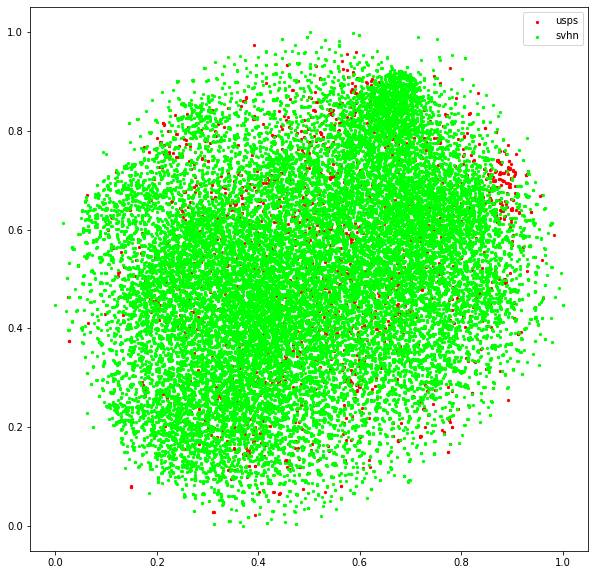

In [ ]:
visualize_tsne(tsne, labels)